# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. У нас имеются исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо построить модель с предельно большим значением *F1*-меры.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Ход работы:**
- [Подготовка данных](#step_1)
- [Исследование задачи](#step_2)
- [Борьба с дисбалансом](#step_3)
    - [Взвешивание классов](#step_3_1)
    - [Увеличение выборки](#step_3_2)
    - [Уменьшение выборки](#step_3_3)
- [Тестирование модели](#step_4)
- [Вывод](#step_5)

<a id='step_1'></a>
## Подготовка данных

In [1]:
# Установим необходимые библиотеки:
# fast_ml:
!pip install fast_ml
# sklearn версии 1.1.3:
!pip install scikit-learn==1.1.3
# imblearn:
! pip install imblearn

     -------------------------------------- 42.1/42.1 kB 338.6 kB/s eta 0:00:00


In [2]:
# Импортируем необходимые библиотеки и модули:
# pandas:
import pandas as pd
# re:
import re
# fast_ml:
from fast_ml.model_development import train_valid_test_split
# sklearn:
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score,
    roc_curve,
    roc_auc_score,
    recall_score
)
# imblearn:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# matplotlib:
import matplotlib.pyplot as plt

In [3]:
# Объявим переменную df и прочитаем данные из csv-файла 'Churn.csv':
df = pd.read_csv('Churn.csv')

In [4]:
# Выведем на экран первые 10 строк всех столбцов датафрейма df:
pd.set_option('display.max_columns', None)
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Краткая информация о столбцах:
- **RowNumber** — индекс строки в данных;
- **CustomerId** — уникальный идентификатор клиента;
- **Surname** — фамилия;
- **CreditScore** — кредитный рейтинг;
- **Geography** — страна проживания;
- **Gender** — пол;
- **Age** — возраст;
- **Tenure** — сколько лет человек является клиентом банка;
- **Balance** — баланс на счёте;
- **NumOfProducts** — количество продуктов банка, используемых клиентом;
- **HasCrCard** — наличие кредитной карты;
- **IsActiveMember** — активность клиента;
- **EstimatedSalary** — предполагаемая зарплата;
- **Exited** — факт ухода клиента.

Обратим внимание, что столбцы **CustomerId** и **Surname** в данном датафрейме выполняют идентичные функции - являются идентификатором уникальности каждого клиента банка. Выясним, сколько одинаковых клиентов присутствует в датафрейме df.

In [5]:
# Найдём количество повторяющихся значений в столбце CustomerId:
df.duplicated(subset=['CustomerId']).sum()

0

Мы выяснили, что каждая строка датафрейма - это уникальный клиент. Для дальнейшего анализа данных и обучения моделей столбцы **RowNumber**,	**CustomerId** и **Surname** нам не понадобятся, так как не несут в себе важной информации о клиентах, а лишь добавляют новые значения.

In [6]:
# Создадим новый датафрейм new_df без столбцов с избыточной информацией:
new_df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [7]:
# Для удобства работы с данными поменяем наименования столбцов в полученном датафрейме new_df:
new_df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in new_df.columns]
# Проверим внесённые изменения:
new_df.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

In [8]:
# Выведем общую информацию о датафрейме new_df:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            9091 non-null   float64
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Обратим внимание на столбец **tenure** (сколько лет человек является клиентом банка) - единственный столбец с пропущенными значениями.

In [9]:
# Выведем на экран первые 10 строк датафрейма new_df с пропущенными значениями:
new_df.query('tenure.isna()').head(10)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
85,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0


In [10]:
# Найдём процент пропущенных значений в столбце 'tenure':
len(new_df.query('tenure.isna()'))/len(new_df) * 100

9.09

Так как каких-либо явных закономерностей в строках с пропущенными данными не обнаружено, мы не можем восстановить точные значения. Замена пропусков усреднёнными значениями может сильно исказить реальную картину. Для более точных предсказаний, избавимся от пропущенных значений, удалив **9.09%** исходных данных.

In [11]:
# Удалим строки с пропущенными значениями в столбце 'tenure':
new_df = new_df.dropna(subset=['tenure'])
# Проверим внесённые изменения:
new_df.isna().sum()

credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

Рассмотрим, как в процентом соотношении представлены данные об уходе клиентов из банка в датафрейме new_df.

In [12]:
# Выясним процент клиентов, покинувших банк:
len(new_df.query('exited == 1'))/len(new_df) * 100

20.393796062039378

В предоставленных нам данных примерно **20.4%** клиентов решили уйти из банка, **79.6%** являются клиентами банка по настоящее время. Наблюдается дисбаланс классов.

In [13]:
# Выведем на экран размеры датафрейма new_df:
new_df.shape

(9091, 11)

In [14]:
# Раздели датафрейм new_df на тренировочную (features_train, target_train),
# валидационную (features_valid, target_valid) и тестовую (features_test, target_test) выборки:
features_train, target_train, features_valid, target_valid, features_test, target_test = train_valid_test_split(
new_df, target='exited', train_size=0.6, valid_size=0.2, test_size=0.2, random_state=12345
)

In [15]:
# Выведем на экран размеры получившихся выборок:
for sample in [features_train, target_train, features_test, target_test, features_valid, target_valid]:
    print(sample.shape)

(5454, 10)
(5454,)
(1819, 10)
(1819,)
(1818, 10)
(1818,)


**Исходные данные:**
- 9091 объект (100%)

**Получившиеся выборки:**
- 5454 объекта (60%) - тренировочная выборка;
- 1819 объектов (20%) - валидационная выборка;
- 1818 объектов (20%) - тестовая выборка.

Применим к категориальным признакам типа 'object' прямое кодирование.

In [16]:
# Создадим список категориальных признаков типа 'object':
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
# Создадим объект стурктуры OneHotEncoder():
# Удалим первый признак из закодированных (drop='first'):
# Проигнорируем ранее невстречающиеся значения признака при transform (handle_unknown='ignore'):
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
# Обучим encoder_ohe на заданных категориальных признаках тренировочной выборки:
encoder_ohe.fit(features_train[ohe_features])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [17]:
# Объявим функцию encoder с одним параметром:
def encoder(features):
    """
    Функция применяет прямое кодирование к заданной выборке.
    
    Параметры:
    features - датафрейм с признаками для заданной выборки.
    """
# Добавляем закодированные признаки в features:
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
    features[
        encoder_ohe.get_feature_names_out()
    ] = encoder_ohe.transform(features[ohe_features])
# Удаляем незакодированные категориальные признаки (изначальные колонки):
    features = features.drop(ohe_features, axis=1)
# Возвращаем закодированный датафрейм с признаками для заданной выборки:    
    return features

In [18]:
# Прямое кодирование тренировочной выборки:
features_train = encoder(features_train)
# Выведем первые пять строк закодированной выборки:
features_train.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
9344,727,28,2.0,110997.76,1,1,0,101433.76,0.0,0.0,0.0
3796,537,26,7.0,106397.75,1,0,0,103563.23,0.0,0.0,1.0
7462,610,40,9.0,0.00,1,1,1,149602.54,0.0,0.0,1.0
1508,576,36,6.0,0.00,2,1,1,48314.00,0.0,0.0,1.0
4478,549,31,4.0,0.00,2,0,1,25684.85,0.0,0.0,1.0


In [19]:
# Прямое кодирование валидационной выборки:
features_valid = encoder(features_valid)
# Выведем первые 5 строк закодированной выборки:
features_valid.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
7445,516,45,4.0,0.00,1,1,0,95273.73,0.0,0.0,0.0
8620,768,40,8.0,0.00,2,0,1,69080.46,0.0,0.0,0.0
1714,730,45,6.0,152880.97,1,0,0,162478.11,1.0,0.0,1.0
5441,751,29,1.0,135536.50,1,1,0,66825.33,0.0,0.0,1.0
9001,688,32,6.0,124179.30,1,1,1,138759.15,0.0,1.0,1.0


In [20]:
# Прямое кодирование тестовой выборки:
features_test = encoder(features_test)
# Выведем первые 5 строк закодированной выборки:
features_test.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
5170,814,31,4.0,0.00,2,1,1,142029.17,0.0,0.0,0.0
4180,607,36,10.0,106702.94,2,0,0,198313.69,1.0,0.0,1.0
7349,632,42,6.0,59972.26,2,0,1,148172.94,1.0,0.0,1.0
7469,686,35,8.0,105419.73,1,1,0,35356.46,0.0,0.0,0.0
3467,538,42,1.0,98548.62,2,0,1,94047.75,1.0,0.0,0.0


Произведём масштабирование количественных признаков.

In [21]:
pd.options.mode.chained_assignment = None

# Создадим переменную, в которую добавим все столбцы с численными признаками:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
# Создадим объект стурктуры StandardScaler():
scaler = StandardScaler()
# произведём настройку объекта scaler на обучающих данных:
scaler.fit(features_train[numeric])
# Преобразуем обучающую, валидационную и тестовую выборки:
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [22]:
# Выведем на экран первые 5 строк датафрейма features_train:
features_train.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
9344,0.809075,-1.039327,-1.025995,0.554904,-0.908179,1,0,0.019508,0.0,0.0,0.0
3796,-1.152518,-1.227561,0.696524,0.480609,-0.908179,0,0,0.056167,0.0,0.0,1.0
7462,-0.398853,0.090079,1.385532,-1.237830,-0.908179,1,1,0.848738,0.0,0.0,1.0
1508,-0.749875,-0.286389,0.352020,-1.237830,0.809300,1,1,-0.894953,0.0,0.0,1.0
4478,-1.028628,-0.756975,-0.336987,-1.237830,0.809300,0,1,-1.284516,0.0,0.0,1.0


В ходе подготовки данных были проделаны следующие шаги:
- было принято решение убрать столбцы, не привносящие в модели машинного обучения важной информации - **RowNumber**, **CustomerId** и **Surname**;
- устранены пропуски в столбце **tenure**. В результате исходный датафрейм сократился на **9.09%**;
- выявлен дисбаланс классов целевого признака - факт ухода клиента: количество клиентов, покинувших банк - **20.4%**, количество клиентов банка - **79.6%**;
- датафрейм был разделён на три выборки в соотношении 3:1:1. В тренировочной выборке насчитывается 5454 объекта (60%), в валидационной - 1819 объектов (20%), в тестовой - 1818 объектов (20%);
- применено прямое кодирование к категориальным признакам и масштабирование численных признаков.

<a id='step_2'></a>
## Исследование задачи

Исследуем данные без учёта дисбаланса класса.

На основе тренировочной выборки обучим три модели в следующем порядке:
- **дерево решений (DecisionTreeClassifier)**,
- **случайный лес (RandomForestClassifier)**,
- **логистическую регрессию (LogisticRegression)**.

При обучении моделей исследуем взаимосвязи различных гиперпараметров и выберем модель с наивысшим показателем **F1-меры** для валидационной выборки.

Начнём с дерева решений (DecisionTreeClassifier). Найдём наилучшую модель (с точки зрения **F1-меры**), отыскав самые оптимальные гиперпараметры среди представленных ниже при помощи цикла:
- **максимальная глубина дерева (max_depth)** - рассмотрим деревья с глубиной от 1 до 10 с шагом 1;
- **минимальное число объектов в узле дерева (min_samples_split)** - будем менять данный параметр от 2 до 15 с шагом 1;
- **минимальное число объектов в листьях дерева (min_samples_leaf)** - будем менять данный параметр от 1 до 10 с шагом 1.

In [23]:
# Объявим функцию model_dtc с тремя параметрами:
def model_dtc(features, target, weight=None):
    """
    Функция model_dtc методом перебора находит наилучшее сочетание гиперпараметров для дерева решений.
    
    Параметры:
    features - датафрейм с признаками тестовой выборки;
    target - датафрейм с целевым признаком тестовой выборки;
    weight - вес классов: 'balanced' или None (None - значение по умолчанию).
    """
# Объявим переменную для сохранения наилучшей модели:
    best_model = None
# Объявим переменную для сохранения наилучшей максимальной глубины дерева: 
    best_depth = 0
# Объявим переменную для сохранения наилучшего минимального числа объектов в узле дерева:     
    best_split = 0
# Объявим переменную для сохранения наилучшего минимального числа объектов в листьях дерева:      
    best_leaf = 0
# Объявим переменную для сохранения наибольшего значения F1-меры:    
    best_result = 0
# В цикле переберём диапазон значений максимальной глубины дерева:
    for depth in range(1, 11):
# Диапазон значений минимального числа объектов в узле дерева:        
        for split in range(2, 16):
# Диапазон значений минимального числа объектов в листьях дерева:  
            for leaf in range(1, 11):
# Рассматриваемая модель - дерево решений с заданными параметрами:
                model = DecisionTreeClassifier(
                    max_depth=depth,
                    min_samples_split=split,
                    min_samples_leaf=leaf,
                    class_weight=weight,
                    random_state=12345)
# Обучим модель на тренировочной выборке:
                model.fit(features, target)
# Предскажем результаты на валидационной выборке:
                predicted_valid = model.predict(features_valid)
# Рассчитаем F1-меру валидационной выборки:
                result = f1_score(target_valid, predicted_valid)
# Если значение F1-меры модели с заданными в этой итерации гиперпараметрами
# наибольшее среди всех предыдущих моделей:
                if result > best_result:
# Сохраним данную модель в перменной best_model:
                    best_model = model
# Сохраним значение максимальной глубины дерева наилучшей модели в переменной best_depth:
                    best_depth = depth
# Сохраним значение минимального числа объектов в узле дерева наилучшей модели в переменной best_split:    
                    best_split = split
# Сохраним значение минимального числа объектов в листьях дерева наилучшей модели в переменной best_leaf:       
                    best_leaf = leaf
# Сохраним значение F1-меры наилучшей модели в переменной best_result:   
                    best_result = result
# Выведем получившиеся значения на экран:                    
    print(f"""Гиперпараметры наилучшей модели: 
                  max_depth={best_depth},
                  min_samples_split={best_split}, 
                  min_samples_leaf={best_leaf}.
                  
              Значение F1-меры: {best_result}.""")
# Вернём наилучшую модель   
    return best_model

In [24]:
%%time
# Отыщем наилучшие сочетания гиперпараметров и сохраним лучшую модель дерева решений в переменной model_dtc1:
model_dtc1 = model_dtc(features_train, target_train)

Гиперпараметры наилучшей модели: 
                  max_depth=7,
                  min_samples_split=13, 
                  min_samples_leaf=6.
                  
              Значение F1-меры: 0.5886075949367088.
CPU times: total: 20.6 s
Wall time: 20.6 s


Следующей обученной моделью будет случайный лес (RandomForestClassifier). Найдём наилучшую модель (с точки зрения **F1-меры**), отыскав самые оптимальные гиперпараметры среди представленных ниже при помощи цикла:
- **максимальная глубина дерева (max_depth)** - рассмотрим деревья с глубиной от 1 до 10 с шагом 1;
- **минимальное число объектов в узле дерева (min_samples_split)** - будем менять данный параметр от 2 до 15 с шагом 1;
- **минимальное число объектов в листьях дерева (min_samples_leaf)** - будем менять данный параметр от 1 до 10 с шагом 2;
- **количество деревьев решений в лесу (n_estimators)** - будем менять данный параметр от 10 до 50 с шагом 10.

In [25]:
# Объявим функцию model_rfc с тремя параметрами:
def model_rfc(features, target, weight=None):
    """
    Функция model_rfc методом перебора находит наилучшее сочетание гиперпараметров для случайного леса.
    
    Параметры:
    features - датафрейм с признаками тестовой выборки;
    target - датафрейм с целевым признаком тестовой выборки;
    weight - вес классов: 'balanced' или None (None - значение по умолчанию).
    """
# Объявим переменную для сохранения наилучшей модели:
    best_model = None
# Объявим переменную для сохранения наилучшей максимальной глубины дерева: 
    best_depth = 0
# Объявим переменную для сохранения наилучшего минимального числа объектов в узле дерева:     
    best_split = 0
# Объявим переменную для сохранения наилучшего минимального числа объектов в листьях дерева:      
    best_leaf = 0
# Объявим переменную для сохранения наилучшего количества деревьев решений в лесу:    
    best_est = 0
# Объявим переменную для сохранения наибольшего значения F1-меры:    
    best_result = 0
# В цикле переберём диапазон значений максимальной глубины дерева:
    for depth in range(1, 11):
# Диапазон значений минимального числа объектов в узле дерева:        
        for split in range(2, 16):
# Диапазон значений минимального числа объектов в листьях дерева:  
            for leaf in range(1, 11):
# Диапазон значений количества деревьев решений в лесу:          
                for est in range(10, 51, 10):
# Рассматриваемая модель - дерево решений с заданными параметрами:
                    model = RandomForestClassifier(
                        max_depth=depth,
                        min_samples_split=split,
                        min_samples_leaf=leaf,
                        n_estimators=est,
                        class_weight=weight,
                        random_state=12345)
# Обучим модель на тренировочной выборке:
                    model.fit(features, target)
# Предскажем результаты на валидационной выборке:
                    predicted_valid = model.predict(features_valid)
# Рассчитаем F1-меру валидационной выборки:
                    result = f1_score(target_valid, predicted_valid)
# Если значение F1-меры модели с заданными в этой итерации гиперпараметрами
# наибольшее среди всех предыдущих моделей:
                    if result > best_result:
# Сохраним данную модель в перменной best_model:
                        best_model = model
# Сохраним значение максимальной глубины дерева наилучшей модели в переменной best_depth:
                        best_depth = depth
# Сохраним значение минимального числа объектов в узле дерева наилучшей модели в переменной best_split:    
                        best_split = split
# Сохраним значение минимального числа объектов в листьях дерева наилучшей модели в переменной best_leaf:       
                        best_leaf = leaf
# Сохраним значение количества деревьев решений в лесу наилучшей модели в переменной best_est:     
                        best_est = est
# Сохраним значение F1-меры наилучшей модели в переменной best_result:   
                        best_result = result
# Выведем получившиеся значения на экран:                    
    print(f"""Гиперпараметры наилучшей модели: 
                  max_depth={best_depth},
                  min_samples_split={best_split}, 
                  min_samples_leaf={best_leaf},
                  n_estimators={best_est}.
                  
              Значение F1-меры: {best_result}.""")
# Вернём наилучшую модель   
    return best_model

In [26]:
%%time
# Отыщем наилучшие сочетания гиперпараметров и сохраним лучшую модель случайного леса в переменной model_rfc1:
model_rfc1 = model_rfc(features_train, target_train)

Гиперпараметры наилучшей модели: 
                  max_depth=10,
                  min_samples_split=13, 
                  min_samples_leaf=3,
                  n_estimators=10.
                  
              Значение F1-меры: 0.603648424543947.
CPU times: total: 13min 23s
Wall time: 13min 24s


Третьей обученной моделью является логистическая регрессия (LogisicRegression). Найдём наилучшую модель (с точки зрения **F1-меры**), отыскав самые оптимальные гиперпараметры среди представленных ниже при помощи цикла:
- **количество итераций обучения (max_iter)** - будем менять данный параметр от 100 до 1000 с шагом 100;
- **алгоритм для постороения модели (solver)** - будем использовать алгоритм 'lbfgs'.

In [27]:
# Объявим функцию model_lr с тремя параметрами:
def model_lr(features, target, weight=None):
    """
    Функция model_rfc методом перебора находит наилучшее сочетание гиперпараметров для логистической регрессии.
    
    Параметры:
    features - датафрейм с признаками тестовой выборки;
    target - датафрейм с целевым признаком тестовой выборки;
    weight - вес классов: 'balanced' или None (None - значение по умолчанию).
    """
# Объявим переменную для сохранения наилучшей модели:
    best_model = None
# Объявим переменную для сохранения наилучшей количества итераций обучения модели: 
    best_iter = 0
# Объявим переменную для сохранения наибольшего значения F1-меры:    
    best_result = 0
# В цикле переберём диапазон значений количества итераций обучения модели:
    for iterations in range(100, 1001, 100):
        model = LogisticRegression(
            max_iter=iterations,
            class_weight=weight,
            random_state=12345)
# Обучим модель на тренировочной выборке:
        model.fit(features, target)
# Предскажем результаты на валидационной выборке:
        predicted_valid = model.predict(features_valid)
# Рассчитаем F1-меру валидационной выборки:
        result = f1_score(target_valid, predicted_valid)
# Если значение F1-меры модели с заданными в этой итерации гиперпараметрами
# наибольшее среди всех предыдущих моделей:
        if result > best_result:
# Сохраним данную модель в перменной best_model:
            best_model = model
# Сохраним значение количества итераций обучения наилучшей модели в переменной best_iter:
            best_iter = iterations
# Сохраним значение F1-меры наилучшей модели в переменной best_result:   
            best_result = result
# Выведем получившиеся значения на экран:                    
    print(f"""Гиперпараметры наилучшей модели: 
                  max_iter={best_iter}.
                  
              Значение F1-меры: {best_result}.""")
# Вернём наилучшую модель   
    return best_model

In [28]:
%%time
# Отыщем наилучшие сочетания гиперпараметров и сохраним лучшую модель логистической регрессии в переменной model_lr1:
model_lr1 = model_lr(features_train, target_train)

Гиперпараметры наилучшей модели: 
                  max_iter=100.
                  
              Значение F1-меры: 0.30400000000000005.
CPU times: total: 172 ms
Wall time: 239 ms


Обучив три разные модели машинного обучения мы методом перебора подобрали наилучшие гиперпараметры для каждой модели в выбранных нами диапазонах. Отыскав таким образом модели с наивысшим значением **F1-меры**, рассчитанным на валидационной выборке. Модели расположились в следующем порядке:

- случайный лес (RandomForestClassifier) - **F1-мера ~ 0.604**;
- дерево решений (DecisionTreeClassifier) - **F1-мера ~ 0.589**;
- логистическая регрессия (LogisticRegression) - **F1-мера ~ 0.304**.

Рассмотрим, как случайный лес с подобранными гиперпараметрами поведёт себя с данными тестовой выборки.

Гипрепараметры наилучшей модели случайного леса:
- максимальная глубина дерева (max_depth) - **10**;
- минимальное число объектов в узле дерева (min_samples_split) - **13**;
- минимальное число объектов в листьях дерева (min_samples_leaf) - **3**;
- количество деревьев решений в лесу (n_estimators) - **10**.

In [29]:
# Предскажем результаты на модели случайного леса на тестовой выборке:
predicted_rfc1 = model_rfc1.predict(features_test)
# Рассчитаем F1-меру для тестовой выборки:
result_rfc1 = f1_score(target_test, predicted_rfc1)
# Выведем полученное значение F1-меры на экран:
print(f'Значение F1-меры: {result_rfc1}')

Значение F1-меры: 0.5647482014388489


На тестовой выборке без учёта дисбаланса классов удалось достичь **значения F1-меры** равное **~0.565**.

Построим ROC-кривую для модели model_rfc1 и сравним её со случайной моделью, рассчитав значение AUC-ROC.

In [30]:
# Объявим функцию roc_auc с двумя параметрами:
def roc_auc(model, title_name):
    """
    Функция строит ROC-кривую для заданной модели и рассчитывает значение ROC-AUC.
    
    Параметры:
    model - модель машинного обучения;
    title_name(str) - заголовок графика.
    """
# Найдём значения вероятностей классов для заданной модели для тестовой выборки:
    probabilities_test = model.predict_proba(features_test)
# Значения вероятностей класса "1" запишем в переменной 'probabilities_one':
    probabilities_one_test = probabilities_test[:, 1]
# Получим три списка значений - FPR, TPR и значения порогов:
    fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
# Зададим область графика:
    plt.figure(figsize=(6, 6))
# Построим график по значениям FPR (ось асбцисс) и TPR (ось ординат):
    plt.plot(fpr, tpr)
# Построим график ROC-кривой случайной модели:
    plt.plot([0, 1], [0, 1], linestyle='--')
# Установим границы по оси абсцисс от 0 до 1:
    plt.xlim([0, 1])
# Установим границы по оси ординат от 0 до 1:
    plt.ylim([0, 1])
# Добавим название оси абсцисс:
    plt.xlabel('False Positive Rate')
# Добавим название оси ординат:
    plt.ylabel('True Positive Rate')
# Добавим заголовок графика:
    plt.title(title_name)
# Выведем график на экран:
    plt.show()
# Рассчитаем значение ROC-AUC для заданной модели:
    auc_roc = roc_auc_score(target_test, probabilities_one_test)
# Выведем полученное значение на экран:
    print(f'Значение ROC-AUC: {auc_roc}')

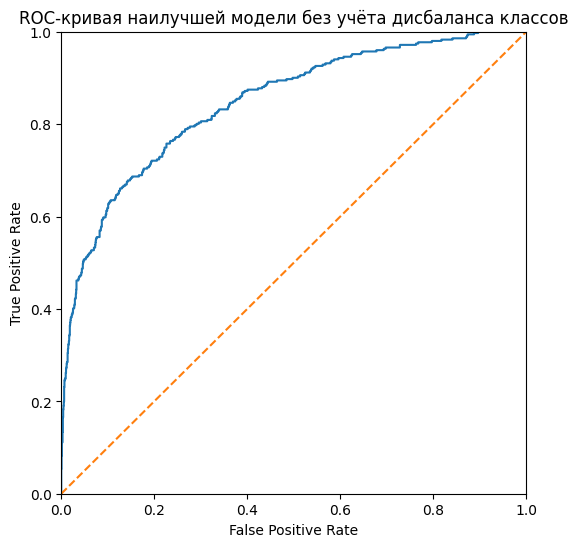

Значение ROC-AUC: 0.846048075952708


In [31]:
# Построим ROC-кривую и рассчитаем ROC-AUC для first_model:
roc_auc(model_rfc1, 'ROC-кривая наилучшей модели без учёта дисбаланса классов')

Без учёта дисбаланса классов нам удалось достичь **значения F1-меры около 0.565** на тестовой выборке для отобранной модели (случайный лес) со следующимим гиперпараметрами:
- максимальная глубина дерева (max_depth) - **10**;
- минимальное число объектов в узле дерева (min_samples_split) - **13**;
- минимальное число объектов в листьях дерева (min_samples_leaf) - **3**;
- количество деревьев решений в лесу (n_estimators) - **10**.

Данное значение **F1-меры** не является удовлетворительным для решения поставленной задачи.

**Значение метрики ROC-AUC равно примерно 0.846** - вероятность того, что наша модель сможет различить положительные и отрицательных значения класса довольно велика.

Далее рассмотрим, как поведут себя модели с учётом дисбаланса классов.

<a id='step_3'></a>
## Борьба с дисбалансом

Для борьбы с дисбалансом рассмотрим три способа:
- **Взвешивание классов**;
- **Увеличение выборки**;
- **Уменьшение выборки**;

В каждом способе обучим три модели в следующем порядке:
- **дерево решений (DecisionTreeClassifier)**,
- **случайный лес (RandomForestClassifier)**,
- **логистическую регрессию (LogisticRegression)**.

Обучив модели каждым из предложенных способов выберем модель с наивысшим показателем **F1-меры** для валидационной выборки.

<a id='step_3_1'></a>
### Взвешивание классов

Сбалансируем веса классов при помощи аргумента **class_weight**.

Диапазон гиперпараметров для дерева решений (DecisionTreeClassifier):
- **максимальная глубина дерева (max_depth)** - рассмотрим деревья с глубиной от 1 до 10 с шагом 1;
- **минимальное число объектов в узле дерева (min_samples_split)** - будем менять данный параметр от 2 до 15 с шагом 1;
- **минимальное число объектов в листьях дерева (min_samples_leaf)** - будем менять данный параметр от 1 до 10 с шагом 1
- **вес классов (class_weight)** - 'balanced'.

In [32]:
%%time
# Отыщем наилучшие сочетания гиперпараметров и сохраним лучшую модель дерева решений в переменной model_dtc2:
model_dtc2 = model_dtc(features_train, target_train, weight='balanced')

Гиперпараметры наилучшей модели: 
                  max_depth=5,
                  min_samples_split=2, 
                  min_samples_leaf=9.
                  
              Значение F1-меры: 0.5762711864406779.
CPU times: total: 22.6 s
Wall time: 22.6 s


Диапазон гиперпараметров для случайного леса (RandomForestClassifier):
- **максимальная глубина дерева (max_depth)** - рассмотрим деревья с глубиной от 1 до 10 с шагом 1;
- **минимальное число объектов в узле дерева (min_samples_split)** - будем менять данный параметр от 2 до 15 с шагом 1;
- **минимальное число объектов в листьях дерева (min_samples_leaf)** - будем менять данный параметр от 1 до 10 с шагом 2;
- **количество деревьев решений в лесу (n_estimators)** - будем менять данный параметр от 10 до 50 с шагом 10;
- **вес классов (class_weight)** - 'balanced'.

In [33]:
%%time
# Отыщем наилучшие сочетания гиперпараметров и сохраним лучшую модель случайного леса в переменной model_rfc2:
model_rfc2 = model_rfc(features_train, target_train, weight='balanced')

Гиперпараметры наилучшей модели: 
                  max_depth=9,
                  min_samples_split=9, 
                  min_samples_leaf=1,
                  n_estimators=30.
                  
              Значение F1-меры: 0.6601226993865031.
CPU times: total: 13min 28s
Wall time: 13min 28s


Диапазон гиперпараметров для логистической регрессии (LogisticRegression):
- **количество итераций обучения (max_iter)** - будем менять данный параметр от 100 до 1000 с шагом 100;
- **алгоритм для постороения модели (solver)** - будем использовать алгоритм 'lbfgs';
- **вес классов (class_weight)** - 'balanced'.

In [34]:
%%time
# Отыщем наилучшие сочетания гиперпараметров и сохраним лучшую модель логистической регрессии в переменной model_lr2:
model_lr2 = model_lr(features_train, target_train, weight='balanced')

Гиперпараметры наилучшей модели: 
                  max_iter=100.
                  
              Значение F1-меры: 0.509731232622799.
CPU times: total: 172 ms
Wall time: 177 ms


Обучив три разные модели машинного обучения мы методом перебора подобрали наилучшие гиперпараметры для каждой модели в выбранных нами диапазонах. Отыскав таким образом модели с наивысшим значением **F1-меры** с учётом дисбаланса классов (сбалансированные веса классов), рассчитанным на валидационной выборке. Модели расположились в следующем порядке:

- случайный лес (RandomForestClassifier) - **F1-мера ~ 0.660** (при дисбалансе классов - ~0.604);
- дерево решений (DecisionTreeClassifier) - **F1-мера ~ 0.576** (при дисбалансе классов - ~0.589);
- логистическая регрессия (LogisticRegression) - **F1-мера ~ 0.510** (при дисбалансе классов - ~0.304).

<a id='step_3_2'></a>
### Увеличение выборки

С помощью **SMOTE** увеличим количество объектов недостающего положительного класса (клиентов, решивших покинуть банк - **20.4%**) до количества объектов отрицательного класса (**79.6%** являются клиентами банка по настоящее время).

In [35]:
# Создадим объект стурктуры SMOTE():
oversample = SMOTE(random_state=12345)
# Приравняем количество объектов положительного класса («1») к количеству объектов отрицательного класса («0»):
features_upsampled, target_upsampled = oversample.fit_resample(features_train, target_train)

In [36]:
# Разобъём тренировочную выборку на группы:
# Признаки объектов с ответом «0»:
features_zeros = features_train[target_train == 0]
# Признаки объектов с ответом «1»:
features_ones = features_train[target_train == 1]

# Разобъём обновлённую тренировочную выборку на группы:
# Целевой признак объектов, у которых ответы только «0»:
features_upsampled_zeros = features_upsampled[target_upsampled == 0]
# Целевой признак объектов, у которых ответы только «1»:
features_upsampled_ones = features_upsampled[target_upsampled == 1]

# Выведем на экран размеры первоначальной выборки с ответом «0»:    
print(f'Размеры первоначальной выборки с ответом «0»: {features_zeros.shape}')
# Выведем на экран размеры первоначальной выборки с ответом «1»:
print(f'Размеры первоначальной выборки с ответом «1»: {features_ones.shape}')
# Выведем на экран размеры обновлённой выборки с ответом «0»:    
print(f'Размеры обновлённой выборки с ответом «0»: {features_upsampled_zeros.shape}')
# Выведем на экран размеры обновлённой выборки с ответом «1»:
print(f'Размеры обновлённой выборки с ответом «1»: {features_upsampled_ones.shape}')
# Выведем на экран первоначальный размер тренировочной выборки:
print(f'Первоначальный размер тренировочной выборки: {features_train.shape}')
# Выведем на экран размер обновлённой тренировочной выборки:
print(f'Размер обновлённой тренировочной выборки: {features_upsampled.shape}')

Размеры первоначальной выборки с ответом «0»: (4328, 11)
Размеры первоначальной выборки с ответом «1»: (1126, 11)
Размеры обновлённой выборки с ответом «0»: (4328, 11)
Размеры обновлённой выборки с ответом «1»: (4328, 11)
Первоначальный размер тренировочной выборки: (5454, 11)
Размер обновлённой тренировочной выборки: (8656, 11)


Диапазон гиперпараметров для дерева решений (DecisionTreeClassifier):
- **максимальная глубина дерева (max_depth)** - рассмотрим деревья с глубиной от 1 до 10 с шагом 1;
- **минимальное число объектов в узле дерева (min_samples_split)** - будем менять данный параметр от 2 до 15 с шагом 1;
- **минимальное число объектов в листьях дерева (min_samples_leaf)** - будем менять данный параметр от 1 до 10 с шагом 1.

In [37]:
%%time
# Отыщем наилучшие сочетания гиперпараметров и сохраним лучшую модель дерева решений в переменной model_dtc3:
model_dtc3 = model_dtc(features_upsampled, target_upsampled)

Гиперпараметры наилучшей модели: 
                  max_depth=9,
                  min_samples_split=15, 
                  min_samples_leaf=3.
                  
              Значение F1-меры: 0.586483390607102.
CPU times: total: 32.7 s
Wall time: 32.7 s


Диапазон гиперпараметров для случайного леса (RandomForestClassifier):
- **максимальная глубина дерева (max_depth)** - рассмотрим деревья с глубиной от 1 до 10 с шагом 1;
- **минимальное число объектов в узле дерева (min_samples_split)** - будем менять данный параметр от 2 до 15 с шагом 1;
- **минимальное число объектов в листьях дерева (min_samples_leaf)** - будем менять данный параметр от 1 до 10 с шагом 2;
- **количество деревьев решений в лесу (n_estimators)** - будем менять данный параметр от 10 до 50 с шагом 10.

In [38]:
%%time
# Отыщем наилучшие сочетания гиперпараметров и сохраним лучшую модель случайного леса в переменной model_rfc3:
model_rfc3 = model_rfc(features_upsampled, target_upsampled)

Гиперпараметры наилучшей модели: 
                  max_depth=10,
                  min_samples_split=2, 
                  min_samples_leaf=1,
                  n_estimators=50.
                  
              Значение F1-меры: 0.6534653465346535.
CPU times: total: 19min 58s
Wall time: 19min 58s


Диапазон гиперпараметров для логистической регрессии (LogisticRegression):
- **количество итераций обучения (max_iter)** - будем менять данный параметр от 100 до 1000 с шагом 100;
- **алгоритм для постороения модели (solver)** - будем использовать алгоритм 'lbfgs'.

In [39]:
%%time
# Отыщем наилучшие сочетания гиперпараметров и сохраним лучшую модель логистической регрессии в переменной model_lr3:
model_lr3 = model_lr(features_upsampled, target_upsampled)

Гиперпараметры наилучшей модели: 
                  max_iter=100.
                  
              Значение F1-меры: 0.5.
CPU times: total: 172 ms
Wall time: 182 ms


Обучив три разные модели машинного обучения мы методом перебора подобрали наилучшие гиперпараметры для каждой модели в выбранных нами диапазонах. Отыскав таким образом модели с наивысшим значением **F1-меры** с учётом дисбаланса классов (увеличение количества объектов недостающего класса), рассчитанным на валидационной выборке. Модели расположились в следующем порядке:

- случайный лес (RandomForestClassifier) - **F1-мера ~ 0.653**:
    - при дисбалансе классов - ~0.604,
    - при взешивании классов - ~0.660;
- дерево решений (DecisionTreeClassifier) - **F1-мера ~ 0.586**:
    - при дисбалансе классов - ~0.589,
    - при взешивании классов - ~0.576;
- логистическая регрессия (LogisticRegression) - **F1-мера ~ 0.500**:
    - при дисбалансе классов - 0.304,
    - при взешивании классов - ~0.510.

<a id='step_3_3'></a>
### Уменьшение выборки

С помощью **RandomUnderSampler** уменьшим количество объектов преобладающего отрицательного класса (**79.6%** являются клиентами банка по настоящее время) до количества объектов положительного класса (клиентов, решивших покинуть банк - **20.4%**).

In [40]:
# Создадим объект стурктуры RandomUnderSampler():
undersample = RandomUnderSampler(random_state=12345)
# Приравняем количество объектов отрицательного класса («0») к количеству объектов положительного класса («1»):
features_downsampled, target_downsampled = undersample.fit_resample(features_train, target_train)

In [41]:
# Разобъём обновлённую тренировочную выборку на группы:
# Целевой признак объектов, у которых ответы только «0»:
features_downsampled_zeros = features_downsampled[target_downsampled == 0]
# Целевой признак объектов, у которых ответы только «1»:
features_downsampled_ones = features_downsampled[target_downsampled == 1]

# Выведем на экран размеры первоначальной выборки с ответом «0»:    
print(f'Размеры первоначальной выборки с ответом «0»: {features_zeros.shape}')
# Выведем на экран размеры первоначальной выборки с ответом «1»:
print(f'Размеры первоначальной выборки с ответом «1»: {features_ones.shape}')
# Выведем на экран размеры обновлённой выборки с ответом «0»:    
print(f'Размеры обновлённой выборки с ответом «0»: {features_downsampled_zeros.shape}')
# Выведем на экран размеры обновлённой выборки с ответом «1»:
print(f'Размеры обновлённой выборки с ответом «1»: {features_downsampled_ones.shape}')
# Выведем на экран первоначальный размер тренировочной выборки:
print(f'Первоначальный размер тренировочной выборки: {features_train.shape}')
# Выведем на экран размер обновлённой тренировочной выборки:
print(f'Размер обновлённой тренировочной выборки: {features_downsampled.shape}')

Размеры первоначальной выборки с ответом «0»: (4328, 11)
Размеры первоначальной выборки с ответом «1»: (1126, 11)
Размеры обновлённой выборки с ответом «0»: (1126, 11)
Размеры обновлённой выборки с ответом «1»: (1126, 11)
Первоначальный размер тренировочной выборки: (5454, 11)
Размер обновлённой тренировочной выборки: (2252, 11)


Диапазон гиперпараметров для дерева решений (DecisionTreeClassifier):
- **максимальная глубина дерева (max_depth)** - рассмотрим деревья с глубиной от 1 до 10 с шагом 1;
- **минимальное число объектов в узле дерева (min_samples_split)** - будем менять данный параметр от 2 до 15 с шагом 1;
- **минимальное число объектов в листьях дерева (min_samples_leaf)** - будем менять данный параметр от 1 до 10 с шагом 1.

In [42]:
%%time
# Отыщем наилучшие сочетания гиперпараметров и сохраним лучшую модель дерева решений в переменной model_dtc4:
model_dtc4 = model_dtc(features_downsampled, target_downsampled)

Гиперпараметры наилучшей модели: 
                  max_depth=8,
                  min_samples_split=2, 
                  min_samples_leaf=9.
                  
              Значение F1-меры: 0.591691995947315.
CPU times: total: 11.9 s
Wall time: 11.9 s


Диапазон гиперпараметров для случайного леса (RandomForestClassifier):
- **максимальная глубина дерева (max_depth)** - рассмотрим деревья с глубиной от 1 до 10 с шагом 1;
- **минимальное число объектов в узле дерева (min_samples_split)** - будем менять данный параметр от 2 до 15 с шагом 1;
- **минимальное число объектов в листьях дерева (min_samples_leaf)** - будем менять данный параметр от 1 до 10 с шагом 2;
- **количество деревьев решений в лесу (n_estimators)** - будем менять данный параметр от 10 до 50 с шагом 10.

In [43]:
%%time
# Отыщем наилучшие сочетания гиперпараметров и сохраним лучшую модель случайного леса в переменной model_rfc4:
model_rfc4 = model_rfc(features_downsampled, target_downsampled)

Гиперпараметры наилучшей модели: 
                  max_depth=10,
                  min_samples_split=11, 
                  min_samples_leaf=3,
                  n_estimators=30.
                  
              Значение F1-меры: 0.6092184368737474.
CPU times: total: 8min 31s
Wall time: 8min 31s


Диапазон гиперпараметров для логистической регрессии (LogisticRegression):
- **количество итераций обучения (max_iter)** - будем менять данный параметр от 100 до 1000 с шагом 100;
- **алгоритм для постороения модели (solver)** - будем использовать алгоритм 'lbfgs'.

In [44]:
%%time
# Отыщем наилучшие сочетания гиперпараметров и сохраним лучшую модель логистической регрессии в переменной model_lr4:
model_lr4 = model_lr(features_downsampled, target_downsampled)

Гиперпараметры наилучшей модели: 
                  max_iter=100.
                  
              Значение F1-меры: 0.502283105022831.
CPU times: total: 141 ms
Wall time: 141 ms


Обучив три разные модели машинного обучения мы методом перебора подобрали наилучшие гиперпараметры для каждой модели в выбранных нами диапазонах. Отыскав таким образом модели с наивысшим значением **F1-меры** с учётом дисбаланса классов (уменьшение количества объектов преобладающего класса), рассчитанным на валидационной выборке. Модели расположились в следующем порядке:

- случайный лес (RandomForestClassifier) - **F1-мера ~ 0.610**:
    - при дисбалансе классов - ~0.604,
    - при взешивании классов - ~0.660,
    - при увеличении выборки - ~0.653;
- дерево решений (DecisionTreeClassifier) - **F1-мера ~ 0.592**:
    - при дисбалансе классов - ~0.589,
    - при взешивании классов - ~0.576,
    - при увеличении выборки - ~0.586;
- логистическая регрессия (LogisticRegression) - **F1-мера ~ 0.502**:
    - при дисбалансе классов - 0.304,
    - при взешивании классов - ~0.510,
    - при увеличении выборки - ~0.500.

Наилучшие результаты показали следующие модели:
- случайный лес при взешивании классов со **значением F1-меры ~0.660**;
- дерево решений при уменьшении выборки со **значением F1-меры ~0.592**;
- логистическая регрессия при уменьшении выборки со **значением F1-меры ~0.502**.

С учётом дисбаланса классов моделью с наивысшим значением **F1-меры** оказалась модель случайного леса со сбалансированными весами классов (**F1-мера ~ 0.660**) со следующимим гиперпараметрами:
- максимальная глубина дерева (max_depth) - **9**;
- минимальное число объектов в узле дерева (min_samples_split) - **9**;
- минимальное число объектов в листьях дерева (min_samples_leaf) - **1**;
- количество деревьев решений в лесу (n_estimators) - **30**.

<a id='step_4'></a>
## Тестирование модели

Рассмотрим, как случайный лес с подобранными гиперпараметрами (model_rfc2) поведёт себя с данными тестовой выборки.

In [45]:
# Предскажем результаты на модели случайного леса на тестовой выборке:
predicted_rfc2 = model_rfc2.predict(features_test)
# Рассчитаем F1-меру для тестовой выборки:
result_rfc2 = f1_score(target_test, predicted_rfc2)
# Выведем полученное значение F1-меры на экран:
print(f'Значение F1-меры: {result_rfc2}')

Значение F1-меры: 0.6128205128205128


Сравним результаты с константной моделью, всегда предсказывающей положительный класс («1»):

In [46]:
# Предскажем результаты на константной модели, которая всегда предсказывает положительный класс («1»):
predicted_constant = pd.Series ([1] * len(target_test))
# Рассчитаем F1-меру для тестовой выборки:
result_constant = f1_score(target_test, predicted_constant)
# Выведем полученное значение F1-меры на экран:
print(f'Значение F1-меры константной модели: {result_constant}')

Значение F1-меры константной модели: 0.3235023041474654


In [47]:
# Рассчитаем значение полноты выбранной модели для тестовой выборки:
recall = recall_score(target_test, predicted_rfc2)
# Выведем полученное значение полноты на экран:
print(f'Значение полноты: {recall}')

Значение полноты: 0.6809116809116809


На тестовой выборке с учётом дисбаланса классов удалось достичь **значения F1-меры равное ~0.613** (почти вдове выше чем у константной модели) и **значение полноты (recall) около 0.681**. Алгоритм верно интерпретирует **около 68%** объектов положительного класса.

Построим ROC-кривую для модели second_model и сравним её со случайной моделью, рассчитав значение AUC-ROC.

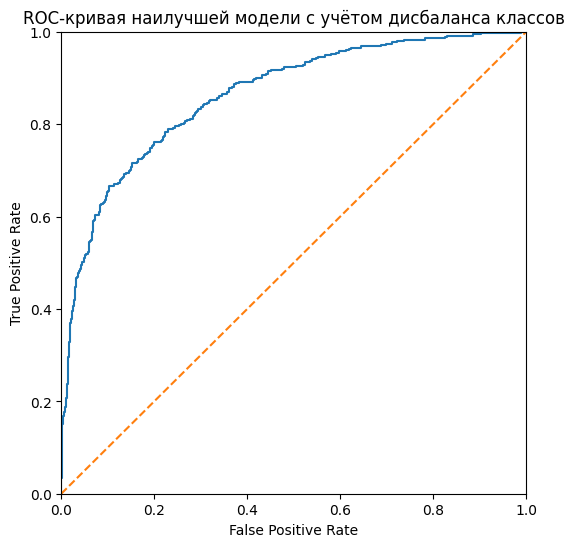

Значение ROC-AUC: 0.8626035383528571


In [48]:
# Построим ROC-кривую и рассчитаем ROC-AUC для first_model:
roc_auc(model_rfc2, 'ROC-кривая наилучшей модели с учётом дисбаланса классов')

С учётом дисбаланса классов нам удалось достичь **значения F1-меры около 0.613** на тестовой выборке для отобранной модели (случайный лес со сбалансированными весами классов). Гиперпараметры наилучшей модели:
- максимальная глубина дерева (max_depth) - **9**;
- минимальное число объектов в узле дерева (min_samples_split) - **9**;
- минимальное число объектов в листьях дерева (min_samples_leaf) - **1**;
- количество деревьев решений в лесу (n_estimators) - **30**.

Данное значение является удовлетворительным для решения поставленной задачи и почти вдове превышает **значения F1-меры** константной модели, всегда предсказывающей уход клиента из банка (**0.324**).

Алгоритм верно интерпретирует **около 68%** объектов положительного класса (клиентов, покидающих банк) - **значение recall около 0.681**.

**Значение метрики ROC-AUC равно примерно 0.863** - вероятность того, что наша модель сможет различить положительные и отрицательных значения класса довольно велика.

<a id='step_5'></a>
## Вывод

Работа над поставленной задачей проводилась в четыре этапа:

**Первый этап - подготовка данных.** В ходе данного этапа:
- было принято решение оптимизировать исходный датафрейм, убрав столбцы **RowNumber**,	**CustomerId** и **Surname**.
- устранены пропуски в столбце **tenure**. В результате исходный датафрейм сократился на **9.09%**;
- выявлен дисбаланс классов целевого признака - факт ухода клиента: количество клиентов, покинувших банк - **20.4%**, количество клиентов банка - **79.6%**;
- датафрейм был разделён на три выборки в соотношении 3:1:1. В тренировочной выборке насчитывается 5454 объекта (60%), в валидационной - 1819 объектов (20%), в тестовой - 1818 объектов (20%);
- применено прямое кодирование к категориальным признакам и масштабирование численных признаков.

**Второй этап - исследование задачи без учёта дисбаланса классов:**
- были обучены три модели машинного обучения - **дерево решений (DecisionTreeClassifier)**, **случайный лес (RandomForestClassifier)** и **логистическая регрессию (LogisticRegression)**;
- определена модель с наивысшим значением **F1-меры** - случайный лес (**F1-мера ~ 0.604** на валидационной выборке и **~ 0.565** на тестовой) с следующими гипрепараметрами:
    - максимальная глубина дерева (max_depth) - **10**;
    - минимальное число объектов в узле дерева (min_samples_split) - **13**;
    - минимальное число объектов в листьях дерева (min_samples_leaf) - **3**;
    - количество деревьев решений в лесу (n_estimators) - **10**.
- построена ROC-кривая и рассчитано значение AUC-ROC (**~0.846**).

**Третий этап - борьба с дисбалансом:**
- было рассмотрено три способа: **взвешивание классов**, **увеличение выборки** и **уменьшение выборки**;
- для каждого способа были обучены различные модели машинного обучения;
- наилучшие результаты показали следующие модели:
    - случайный лес при взешивании классов со **значением F1-меры ~0.660**;
    - дерево решений при уменьшении выборки со **значением F1-меры ~0.592**;
    - логистическая регрессия при уменьшении выборки со **значением F1-меры ~0.502**.
- определена модель с наивысшим значением **F1-меры** - случайный лес (**F1-мера ~ 0.660** на валидационной выборке) со следующимим гиперпараметрами:
    - максимальная глубина дерева (max_depth) - **9**;
    - минимальное число объектов в узле дерева (min_samples_split) - **9**;
    - минимальное число объектов в листьях дерева (min_samples_leaf) - **1**;
    - количество деревьев решений в лесу (n_estimators) - **30**.

**Четвёртый этап - тестирование модели:**
- для выбранной модели было рассчитано значение **F1-меры** на тестовой выборке (**~0.613**);
- проведено сравнение с константной моделью, всегда предсказывающей уход клиента из банка (**F1-мера ~0.324**). Значение **F1-меры** выбранной нами модели почти вдвое превышает значение константной;
- рассчитано **значение полноты (recall) равное ~0.681**. Алгоритм верно интерпретирует **около 68%** объектов положительного класса (клиентов, покидающих банк);
- построена ROC-кривая и рассчитано значение AUC-ROC (**~0.863**) - вероятность того, что наша модель сможет различить положительные и отрицательных значения класса довольно велика.